In [2]:
# import header files
import torch
import torch.nn as nn
import torchvision
import numpy as np

In [3]:
# from google.colab import drive
# drive.mount('/content/drive')

In [4]:
np.random.seed(1234)
torch.manual_seed(1234)
torch.cuda.manual_seed(1234)

# DATA LOAD

In [5]:
import pandas as pd

In [6]:
# Load the DataFrame back
df_train = pd.read_pickle('DATASET_PREPROCESS/afterArrayNpTrain.pkl')
df_public_test = pd.read_pickle('DATASET_PREPROCESS/afterArrayNpPublicTest.pkl')

In [7]:
df_train.head()

,emotion,usage,resized_pixels
0,0,Training,"[[69.0, 71.0, 77.0, 84.0, 86.0, 84.0, 80.0, 72..."
1,0,Training,"[[151.0, 151.0, 151.0, 149.0, 147.0, 148.0, 15..."
2,2,Training,"[[230.0, 232.0, 227.0, 205.0, 173.0, 154.0, 15..."
3,4,Training,"[[23.0, 25.0, 28.0, 34.0, 37.0, 36.0, 32.0, 29..."
4,6,Training,"[[6.0, 3.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,..."


In [8]:
# import numpy as np
# import albumentations as A
# import cv2
# import torch
# from torch.utils.data import Dataset, DataLoader
# from albumentations.pytorch import ToTensorV2
# import random

# class FERDataset(Dataset):
#     def __init__(self, dataframe, transform=None):
#         self.data = dataframe
#         self.transform = transform

#     def __len__(self):
#         return len(self.data)

#     def __getitem__(self, idx):
#         pixels = np.array(self.data.iloc[idx]['resized_pixels'], dtype=np.uint8)  # Convert to NumPy array
#         pixels = np.expand_dims(pixels, axis=-1)  # Convert to (100, 100, 1)

#         label = int(self.data.iloc[idx]['emotion'])  # Get emotion label
        
#         # Apply Albumentations transforms
#         if self.transform:
#             augmented = self.transform(image=pixels)
#             pixels = augmented['image']

#         return pixels, label

# def dynamic_prob():
#     return random.uniform(0.0, 1.0)  # Probabilitas berubah setiap panggilan

# def dynamic_rotate():
#     return random.randint(10, 30)  # Rotasi acak antara 10-30 derajatmin_size=8

# train_transforms = A.Compose([
#     A.OneOf([
#         A.CenterCrop(85, 95),  # Crop ukuran random --> coba make random probablity, nah cek print sama ngk setiap manggil
#         A.RandomCrop(85, 95) 
#     ], p=dynamic_prob()),
#     A.PadIfNeeded(100, 100, border_mode=cv2.BORDER_REFLECT),  
#     A.Rotate(limit=dynamic_rotate(), border_mode=cv2.BORDER_REFLECT_101, p=dynamic_prob()),  # Rotasi dinamis
#     A.Resize(100, 100),
#     A.HorizontalFlip(p=dynamic_prob()),  # Probabilitas flip dinamis
#     A.ColorJitter(brightness=0.3, contrast=0.3, saturation=0.3, hue=0.5, p=dynamic_prob()),
#     A.CoarseDropout(
#         num_holes_range=(1, 3),
#         hole_height_range=(10, 15),
#         hole_width_range=(10, 15),
#         fill=0,
#         p=dynamic_prob()  # Probabilitas dinamis
#     ),
#     A.Normalize(mean=[0], std=[255]),
#     ToTensorV2()
# ])

# # Transformasi untuk validasi (tanpa augmentasi)
# val_transforms = A.Compose([
#     A.Resize(100, 100),
#     A.Normalize(mean=[0], std=[255]),
#     ToTensorV2()
# ])

In [9]:
import numpy as np
import albumentations as A
import cv2
import torch
from torch.utils.data import Dataset, DataLoader
from albumentations.pytorch import ToTensorV2
import random

class FERDataset(Dataset):
    def __init__(self, dataframe, transform=None):
        self.data = dataframe
        self.transform = transform

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        pixels = np.array(self.data.iloc[idx]['resized_pixels'], dtype=np.uint8)  # Convert to NumPy array
        pixels = np.expand_dims(pixels, axis=-1)  # Convert to (100, 100, 1)

        label = int(self.data.iloc[idx]['emotion'])  # Get emotion label
        
        # Apply Albumentations transforms
        if self.transform:
            augmented = self.transform(image=pixels)
            pixels = augmented['image']

        return pixels, label

# 🔥 Dynamic Functions
def dynamic_prob():
    return random.uniform(0.0, 1.0)  # Tidak terlalu kecil, tidak terlalu besar

def dynamic_rotate():
    return random.randint(-40, 40)  # Lebih kecil agar tidak terlalu mengubah ekspresi wajah

def dynamic_crop_size():
    size = random.randint(80, 99)  # Tidak crop terlalu kecil agar wajah tidak hilang
    return size, size  # (H, W)

def dynamic_color_jitter():
    return A.ColorJitter(
        brightness=(0.1, 1.3),  # Sedikit lebih luas, mencegah terlalu gelap/terang
        contrast=(0.1,2),  # Mencegah gambar terlalu datar atau terlalu ekstrem
        saturation=(0.1,2),  # Hindari grayscale total
        hue=(-0.5,0.5),  # Tidak terlalu jauh agar warna wajah tidak aneh
        p=dynamic_prob()
    )

def get_train_transforms():
    return A.Compose([
        A.OneOf([
            A.CenterCrop(*dynamic_crop_size()),
            A.RandomCrop(*dynamic_crop_size())
        ], p=dynamic_prob()),
        A.PadIfNeeded(100, 100, border_mode=cv2.BORDER_REFLECT_101, p=dynamic_prob()),
        A.Rotate(limit=dynamic_rotate(), border_mode=cv2.BORDER_REFLECT_101, p=dynamic_prob()),  
        A.Resize(100, 100),
        A.HorizontalFlip(p=dynamic_prob()),
        dynamic_color_jitter(),  # ✅ Warna berubah pemganggilan
        A.CoarseDropout(           
            num_holes_range=(1, 5),
            hole_height_range=(5, 15),
            hole_width_range=(5, 15),
            fill=0,
            p=dynamic_prob()  # Probabilitas dinamis
        ),
        A.Normalize(mean=[0], std=[255]),
        ToTensorV2()
    ])
    
# Transformasi untuk validasi (tanpa augmentasi)
val_transforms = A.Compose([
    A.Resize(100, 100),
    A.Normalize(mean=[0], std=[255]),
    ToTensorV2()
])

/home/user-labai-4/scriptc/lib/python3.12/site-packages/albumentations/__init__.py:28: UserWarning: A new version of Albumentations is available: '2.0.8' (you have '2.0.5'). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()


In [10]:
# Inisialisasi dataset
train_transforms = get_train_transforms()
train_dataset = FERDataset(df_train, transform=train_transforms)
val_dataset = FERDataset(df_public_test, transform=val_transforms)

# Buat DataLoader
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True, num_workers=4, pin_memory=True)
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False, num_workers=4, pin_memory=True)  # Opsional

Compose([
  OneOf([
    CenterCrop(p=1.0, height=81, width=81, pad_if_needed=False, border_mode=0, fill=0.0, fill_mask=0.0, pad_position='center'),
    RandomCrop(p=1.0, height=88, width=88, pad_if_needed=False, border_mode=0, fill=0.0, fill_mask=0.0, pad_position='center'),
  ], p=0.7441627764724058),
  PadIfNeeded(p=0.6472838883735308, min_height=100, min_width=100, pad_height_divisor=None, pad_width_divisor=None, position='center', border_mode=4, fill=0.0, fill_mask=0.0),
  Rotate(p=0.6112456336332409, limit=(-37.0, 37.0), interpolation=1, border_mode=4, fill=0.0, fill_mask=0.0, rotate_method='largest_box', crop_border=False, mask_interpolation=0),
  Resize(p=1.0, height=100, width=100, interpolation=1, mask_interpolation=0),
  HorizontalFlip(p=0.7370875519561011),
  ColorJitter(p=0.36145357439752734, brightness=(0.1, 1.3), contrast=(0.1, 2.0), saturation=(0.1, 2.0), hue=(-0.5, 0.5)),
  CoarseDropout(p=0.8829630613271253, fill=0.0, fill_mask=None, num_holes_range=(1, 5), hole_height

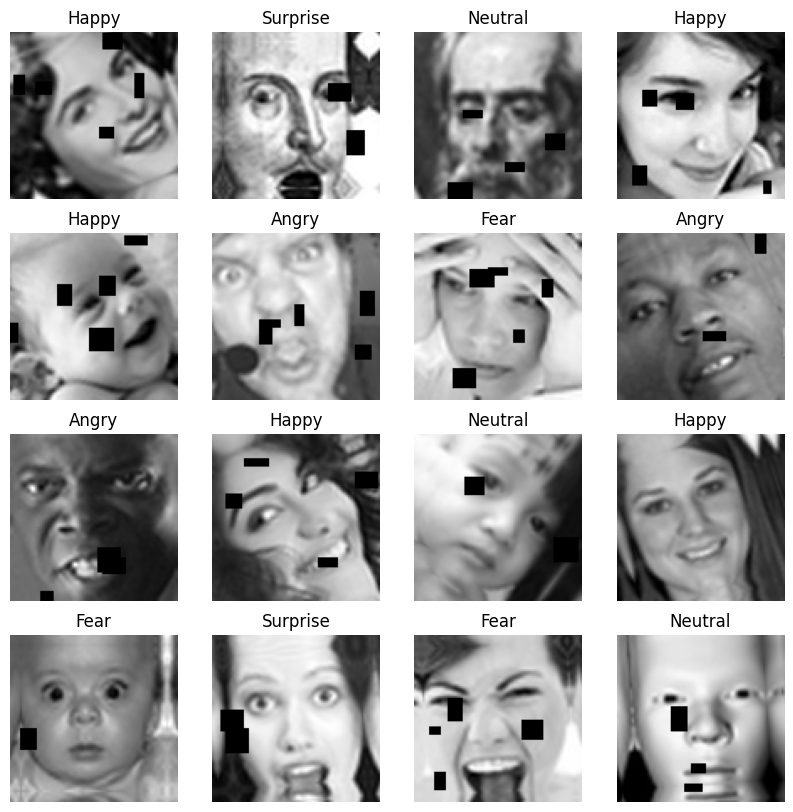

In [11]:
import matplotlib.pyplot as plt
import torchvision.utils

print(train_dataset.transform)  # Cek apakah transformasi benar-benar berubah setiap epoch


# Fungsi untuk menampilkan gambar dari DataLoader
def show_images(dataloader, class_names, num_images=16):
    images_shown = 0
    fig, axes = plt.subplots(4, 4, figsize=(10, 10))  # Grid 4x4

    for images, labels in dataloader:
        for i in range(num_images):
            ax = axes[i // 4, i % 4]
            img = images[i].squeeze(0).cpu().numpy()  # Hapus channel dimensi (1, H, W) -> (H, W)
            ax.imshow(img, cmap="gray")  # Tampilkan dalam grayscale
            ax.set_title(class_names[labels[i].item()])  # Ambil nama kelas dari indeks label
            ax.axis("off")
            
            images_shown += 1
            if images_shown >= num_images:
                plt.show()
                return

# Dictionary label berdasarkan indeks (sesuaikan dengan dataset FER-2013)
class_names = {0: "Angry", 1: "Disgust", 2: "Fear", 3: "Happy", 4: "Sad", 5: "Surprise", 6: "Neutral"}

# Tampilkan beberapa gambar dari train_loader
show_images(train_loader, class_names)

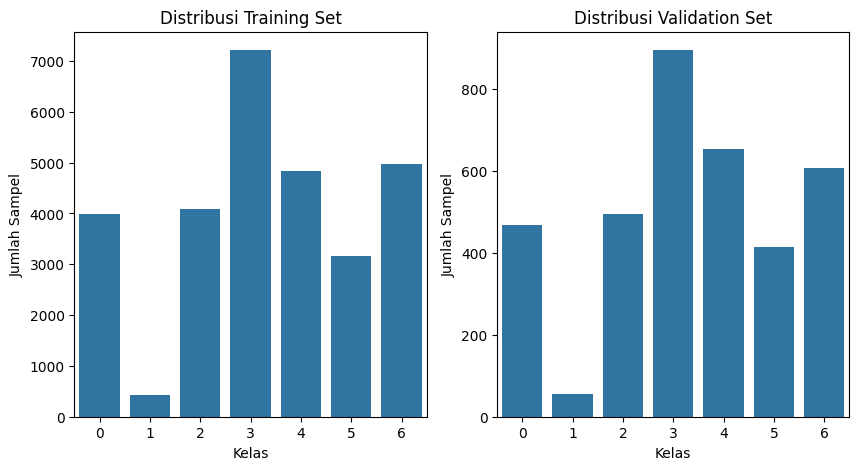

In [12]:
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter

# Kumpulkan semua label dari DataLoader
train_labels = []
val_labels = []

for _, targets in train_loader:
    train_labels.extend(targets.numpy())  # Simpan label dari batch

for _, targets in val_loader:
    val_labels.extend(targets.numpy())  # Simpan label dari batch

# Hitung distribusi kelas
train_counts = Counter(train_labels)
val_counts = Counter(val_labels)

# Plot distribusi kelas
plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
sns.barplot(x=list(train_counts.keys()), y=list(train_counts.values()))
plt.title("Distribusi Training Set")
plt.xlabel("Kelas")
plt.ylabel("Jumlah Sampel")

plt.subplot(1, 2, 2)
sns.barplot(x=list(val_counts.keys()), y=list(val_counts.values()))
plt.title("Distribusi Validation Set")
plt.xlabel("Kelas")
plt.ylabel("Jumlah Sampel")

plt.show()

In [13]:
for images, labels in train_loader:
    print(images.shape)  # Harusnya (batch_size, 1, 100, 100)
    break


torch.Size([64, 1, 100, 100])


# DEFINE FUNCTION MODELS

RESNET18

In [14]:
# import torch
# import torch.nn as nn
# import torchvision.models as models

# class ResNet18(nn.Module):
#     def __init__(self, num_classes=7):
#         super(ResNet18, self).__init__()
#         self.resnet18 = models.resnet18(weights=models.ResNet18_Weights.DEFAULT)  # Load pretrained model
#         # Ubah input layer dari 3 channel menjadi 1 channel
#         self.resnet18.conv1 = nn.Conv2d(1, 64, kernel_size=7, stride=2, padding=3, bias=False)

#         # Ganti fully connected layer agar sesuai dengan jumlah kelas
#         in_features = self.resnet18.fc.in_features
#         self.resnet18.fc = nn.Linear(in_features, num_classes)

#     def forward(self, x):
#         return self.resnet18(x)

RESNET18 & CBAM

In [15]:
# # import torch

# # # define model
# # class ResNet18_CBAM(torch.nn.Module):
    
# #     # block definition - ResNet18 uses basic blocks rather than bottleneck blocks
# #     def basic_block(self, in_features, out_features, stride=1):
# #         return torch.nn.Sequential(
# #             torch.nn.Conv2d(in_features, out_features, kernel_size=3, stride=stride, padding=1),
# #             torch.nn.BatchNorm2d(out_features),
# #             torch.nn.ReLU(inplace=True),
# #             torch.nn.Conv2d(out_features, out_features, kernel_size=3, padding=1),
# #             torch.nn.BatchNorm2d(out_features)
# #         )
    
# #     # init function
# #     def __init__(self, num_classes=7):
# #         super(ResNet18_CBAM, self).__init__()
        
# #         # initial layers
# #         self.features = torch.nn.Sequential(
# #             torch.nn.Conv2d(1, 64, kernel_size=7, stride=2, padding=3),
# #             torch.nn.BatchNorm2d(64),
# #             torch.nn.ReLU(inplace=True)
# #         )
        
# #         self.pool = torch.nn.Sequential(torch.nn.MaxPool2d(kernel_size=3, stride=2, padding=1))
        
# #         # spatial attention
# #         self.spatial_attention = torch.nn.Sequential(
# #             torch.nn.Conv2d(2, 1, kernel_size=7, padding=3, stride=1),
# #             torch.nn.BatchNorm2d(1),
# #             torch.nn.Sigmoid()
# #         )
        
# #         # channel attention pooling operations
# #         self.max_pool_11 = torch.nn.AdaptiveMaxPool2d(1)
# #         self.max_pool_1 = torch.nn.AdaptiveMaxPool2d(1)
# #         self.max_pool_2 = torch.nn.AdaptiveMaxPool2d(1)
# #         self.max_pool_3 = torch.nn.AdaptiveMaxPool2d(1)
# #         self.max_pool_4 = torch.nn.AdaptiveMaxPool2d(1)
        
# #         self.avg_pool_11 = torch.nn.AdaptiveAvgPool2d(1)
# #         self.avg_pool_1 = torch.nn.AdaptiveAvgPool2d(1)
# #         self.avg_pool_2 = torch.nn.AdaptiveAvgPool2d(1)
# #         self.avg_pool_3 = torch.nn.AdaptiveAvgPool2d(1)
# #         self.avg_pool_4 = torch.nn.AdaptiveAvgPool2d(1)

        
# #         # ResNet18 blocks - 2 for each layer
# #         # layer 1 (64 -> 64)
# #         self.resnet_block_1_1 = self.basic_block(64, 64)
# #         self.resnet_block_1_2 = self.basic_block(64, 64)
        
# #         # layer 2 (64 -> 128)
# #         self.resnet_block_2_1 = self.basic_block(64, 128, stride=2)
# #         self.resnet_block_2_2 = self.basic_block(128, 128)
        
# #         # layer 3 (128 -> 256)
# #         self.resnet_block_3_1 = self.basic_block(128, 256, stride=2)
# #         self.resnet_block_3_2 = self.basic_block(256, 256)
        
# #         # layer 4 (256 -> 512)
# #         self.resnet_block_4_1 = self.basic_block(256, 512, stride=2)
# #         self.resnet_block_4_2 = self.basic_block(512, 512)
        
# #         # skip connection layers
# #         self.skip_connection_1 = torch.nn.Identity()  # No transformation needed
        
# #         self.skip_connection_2 = torch.nn.Sequential(
# #             torch.nn.Conv2d(64, 128, kernel_size=1, stride=2),
# #             torch.nn.BatchNorm2d(128)
# #         )
        
# #         self.skip_connection_3 = torch.nn.Sequential(
# #             torch.nn.Conv2d(128, 256, kernel_size=1, stride=2),
# #             torch.nn.BatchNorm2d(256)
# #         )
        
# #         self.skip_connection_4 = torch.nn.Sequential(
# #             torch.nn.Conv2d(256, 512, kernel_size=1, stride=2),
# #             torch.nn.BatchNorm2d(512)
# #         )
        
# #         # final layers
# #         self.avgpool = torch.nn.AdaptiveAvgPool2d((1, 1))
# #         self.classifier = torch.nn.Linear(512, num_classes)
# #         self.relu = torch.nn.ReLU(inplace=True)
        
# #     # define forward function
# #     def forward(self, x):
# #         # apply initial conv layers
# #         x = self.features(x)
        
# #         # apply channel and spatial attention
# #         scale = torch.nn.functional.sigmoid(self.max_pool_11(x) + self.avg_pool_11(x)).expand_as(x)
# #         x = x * scale
        
# #         scale = torch.cat((torch.max(x, 1)[0].unsqueeze(1), torch.mean(x, 1).unsqueeze(1)), dim=1)
# #         scale = self.spatial_attention(scale)
# #         x = x * scale
        
# #         x = self.pool(x)
        
# #         # layer 1 - block 1
# #         input_1 = x
# #         x = self.resnet_block_1_1(x)
        
# #         # apply channel and spatial attention
# #         scale = torch.nn.functional.sigmoid(self.max_pool_1(x) + self.avg_pool_1(x)).expand_as(x)
# #         x = x * scale
# #         scale = torch.cat((torch.max(x, 1)[0].unsqueeze(1), torch.mean(x, 1).unsqueeze(1)), dim=1)
# #         scale = self.spatial_attention(scale)
# #         x = x * scale
        
# #         # add skip connection and apply ReLU
# #         x = torch.add(input_1, x)
# #         x = self.relu(x)
        
# #         # layer 1 - block 2
# #         input_1 = x
# #         x = self.resnet_block_1_2(x)
        
# #         # apply channel and spatial attention
# #         scale = torch.nn.functional.sigmoid(self.max_pool_1(x) + self.avg_pool_1(x)).expand_as(x)
# #         x = x * scale
# #         scale = torch.cat((torch.max(x, 1)[0].unsqueeze(1), torch.mean(x, 1).unsqueeze(1)), dim=1)
# #         scale = self.spatial_attention(scale)
# #         x = x * scale
        
# #         # add skip connection and apply ReLU
# #         x = torch.add(input_1, x)
# #         x = self.relu(x)
        
# #         # layer 2 - block 1
# #         input_2 = self.skip_connection_2(x)
# #         x = self.resnet_block_2_1(x)
        
# #         # apply channel and spatial attention
# #         scale = torch.nn.functional.sigmoid(self.max_pool_2(x) + self.avg_pool_2(x)).expand_as(x)
# #         x = x * scale
# #         scale = torch.cat((torch.max(x, 1)[0].unsqueeze(1), torch.mean(x, 1).unsqueeze(1)), dim=1)
# #         scale = self.spatial_attention(scale)
# #         x = x * scale
        
# #         # add skip connection and apply ReLU
# #         x = torch.add(input_2, x)
# #         x = self.relu(x)
        
# #         # layer 2 - block 2
# #         input_2 = x
# #         x = self.resnet_block_2_2(x)
        
# #         # apply channel and spatial attention
# #         scale = torch.nn.functional.sigmoid(self.max_pool_2(x) + self.avg_pool_2(x)).expand_as(x)
# #         x = x * scale
# #         scale = torch.cat((torch.max(x, 1)[0].unsqueeze(1), torch.mean(x, 1).unsqueeze(1)), dim=1)
# #         scale = self.spatial_attention(scale)
# #         x = x * scale
        
# #         # add skip connection and apply ReLU
# #         x = torch.add(input_2, x)
# #         x = self.relu(x)
        
# #         # layer 3 - block 1
# #         input_3 = self.skip_connection_3(x)
# #         x = self.resnet_block_3_1(x)
        
# #         # apply channel and spatial attention
# #         scale = torch.nn.functional.sigmoid(self.max_pool_3(x) + self.avg_pool_3(x)).expand_as(x)
# #         x = x * scale
# #         scale = torch.cat((torch.max(x, 1)[0].unsqueeze(1), torch.mean(x, 1).unsqueeze(1)), dim=1)
# #         scale = self.spatial_attention(scale)
# #         x = x * scale
        
# #         # add skip connection and apply ReLU
# #         x = torch.add(input_3, x)
# #         x = self.relu(x)
        
# #         # layer 3 - block 2
# #         input_3 = x
# #         x = self.resnet_block_3_2(x)
        
# #         # apply channel and spatial attention
# #         scale = torch.nn.functional.sigmoid(self.max_pool_3(x) + self.avg_pool_3(x)).expand_as(x)
# #         x = x * scale
# #         scale = torch.cat((torch.max(x, 1)[0].unsqueeze(1), torch.mean(x, 1).unsqueeze(1)), dim=1)
# #         scale = self.spatial_attention(scale)
# #         x = x * scale
        
# #         # add skip connection and apply ReLU
# #         x = torch.add(input_3, x)
# #         x = self.relu(x)
        
# #         # layer 4 - block 1
# #         input_4 = self.skip_connection_4(x)
# #         x = self.resnet_block_4_1(x)
        
# #         # apply channel and spatial attention
# #         scale = torch.nn.functional.sigmoid(self.max_pool_4(x) + self.avg_pool_4(x)).expand_as(x)
# #         x = x * scale
# #         scale = torch.cat((torch.max(x, 1)[0].unsqueeze(1), torch.mean(x, 1).unsqueeze(1)), dim=1)
# #         scale = self.spatial_attention(scale)
# #         x = x * scale
        
# #         # add skip connection and apply ReLU
# #         x = torch.add(input_4, x)
# #         x = self.relu(x)
        
# #         # layer 4 - block 2
# #         input_4 = x
# #         x = self.resnet_block_4_2(x)
        
# #         # apply channel and spatial attention
# #         scale = torch.nn.functional.sigmoid(self.max_pool_4(x) + self.avg_pool_4(x)).expand_as(x)
# #         x = x * scale
# #         scale = torch.cat((torch.max(x, 1)[0].unsqueeze(1), torch.mean(x, 1).unsqueeze(1)), dim=1)
# #         scale = self.spatial_attention(scale)
# #         x = x * scale
        
# #         # add skip connection and apply ReLU
# #         x = torch.add(input_4, x)
# #         x = self.relu(x)
        
# #         # final classification
# #         x = self.avgpool(x)
# #         x = x.view(x.size(0), -1)
# #         x = self.classifier(x)
        
# #         return x


# import torch
# import torch.nn as nn
# import torchvision.models as models
# import torch.nn.functional as F

# # Channel Attention Module
# class ChannelAttention(nn.Module):
#     def __init__(self, in_channels, ratio=16):
#         super(ChannelAttention, self).__init__()
#         self.avg_pool = nn.AdaptiveAvgPool2d(1)
#         self.max_pool = nn.AdaptiveMaxPool2d(1)

#         self.fc = nn.Sequential(
#             nn.Linear(in_channels, in_channels // ratio, bias=False),
#             nn.ReLU(),
#             nn.Linear(in_channels // ratio, in_channels, bias=False)
#         )
#         self.sigmoid = nn.Sigmoid()

#     def forward(self, x):
#         b, c, _, _ = x.size()
#         avg_out = self.fc(self.avg_pool(x).view(b, c))
#         max_out = self.fc(self.max_pool(x).view(b, c))
#         out = avg_out + max_out
#         return x * self.sigmoid(out).view(b, c, 1, 1)

# # Spatial Attention Module
# class SpatialAttention(nn.Module):
#     def __init__(self, kernel_size=7):
#         super(SpatialAttention, self).__init__()
#         self.conv = nn.Conv2d(2, 1, kernel_size=kernel_size, padding=kernel_size // 2, bias=False)
#         self.sigmoid = nn.Sigmoid()

#     def forward(self, x):
#         avg_out = torch.mean(x, dim=1, keepdim=True)
#         max_out, _ = torch.max(x, dim=1, keepdim=True)
#         out = torch.cat([avg_out, max_out], dim=1)
#         out = self.conv(out)
#         return x * self.sigmoid(out)

# # CBAM Block
# class CBAM(nn.Module):
#     def __init__(self, in_channels, ratio=16, kernel_size=7):
#         super(CBAM, self).__init__()
#         self.channel_attention = ChannelAttention(in_channels, ratio)
#         self.spatial_attention = SpatialAttention(kernel_size)

#     def forward(self, x):
#         x = self.channel_attention(x)
#         x = self.spatial_attention(x)
#         return x

# # Modifikasi ResNet-18 untuk Grayscale + CBAM
# class ResNet18_CBAM(nn.Module):
#     def __init__(self, num_classes=7):
#         super(ResNet18_CBAM, self).__init__()
#         self.resnet18 = models.resnet18(weights=models.ResNet18_Weights.DEFAULT)

#         # Ubah input layer agar menerima grayscale (1 channel)
#         self.resnet18.conv1 = nn.Conv2d(1, 64, kernel_size=7, stride=2, padding=3, bias=False)

#         # Tambahkan CBAM di setiap blok residual
#         self.cbam1 = CBAM(64)
#         self.cbam2 = CBAM(128)
#         self.cbam3 = CBAM(256)
#         self.cbam4 = CBAM(512)

#         # Ganti fully connected layer agar sesuai jumlah kelas
#         in_features = self.resnet18.fc.in_features
#         self.resnet18.fc = nn.Linear(in_features, num_classes)

#     def forward(self, x):
#         x = self.resnet18.conv1(x)
#         x = self.resnet18.bn1(x)
#         x = self.resnet18.relu(x)
#         x = self.resnet18.maxpool(x)

#         x = self.cbam1(self.resnet18.layer1(x))
#         x = self.cbam2(self.resnet18.layer2(x))
#         x = self.cbam3(self.resnet18.layer3(x))
#         x = self.cbam4(self.resnet18.layer4(x))

#         x = self.resnet18.avgpool(x)
#         x = torch.flatten(x, 1)
#         x = self.resnet18.fc(x)

#         return x

RESNET + CBAM + CIRCULAR LBP

In [16]:
# # MAKE INI LABEL 1 BISA KEDETEKSI

# import torch
# import torch.nn as nn
# import torchvision.models as models
# import torch.nn.functional as F
# import numpy as np
# from skimage.feature import local_binary_pattern

# # Channel Attention Module
# class ChannelAttention(nn.Module):
#     def __init__(self, in_channels, ratio=16):
#         super(ChannelAttention, self).__init__()
#         self.avg_pool = nn.AdaptiveAvgPool2d(1)
#         self.max_pool = nn.AdaptiveMaxPool2d(1)
        
#         self.fc = nn.Sequential(
#             nn.Linear(in_channels, in_channels // ratio, bias=False),
#             nn.ReLU(),
#             nn.Linear(in_channels // ratio, in_channels, bias=False)
#         )
#         self.sigmoid = nn.Sigmoid()

#     def forward(self, x):
#         b, c, _, _ = x.size()
#         avg_out = self.fc(self.avg_pool(x).view(b, c))
#         max_out = self.fc(self.max_pool(x).view(b, c))
#         out = avg_out + max_out
#         return x * self.sigmoid(out).view(b, c, 1, 1)

# # Spatial Attention Module
# class SpatialAttention(nn.Module):
#     def __init__(self, kernel_size=7):
#         super(SpatialAttention, self).__init__()
#         self.conv = nn.Conv2d(2, 1, kernel_size=kernel_size, padding=kernel_size // 2, bias=False)
#         self.sigmoid = nn.Sigmoid()

#     def forward(self, x):
#         avg_out = torch.mean(x, dim=1, keepdim=True)
#         max_out, _ = torch.max(x, dim=1, keepdim=True)
#         out = torch.cat([avg_out, max_out], dim=1)
#         out = self.conv(out)
#         return x * self.sigmoid(out)

# # CBAM Block
# class CBAM(nn.Module):
#     def __init__(self, in_channels, ratio=16, kernel_size=7):
#         super(CBAM, self).__init__()
#         self.channel_attention = ChannelAttention(in_channels, ratio)
#         self.spatial_attention = SpatialAttention(kernel_size)

#     def forward(self, x):
#         x = self.channel_attention(x)
#         x = self.spatial_attention(x)
#         return x

# # LBP Feature Extractor
# class LBPExtractor(nn.Module):
#     def __init__(self, P=8, R=1):
#         super(LBPExtractor, self).__init__()
#         self.P = P
#         self.R = R

#     def forward(self, x):
#         x = x.squeeze(1).detach().cpu().numpy()  # Pastikan aman
#         lbp_features = []
#         for img in x:          
#             # print(f"SEBELUM LBP Min: {img.min()}, Max: {img.max()}, type: {img.dtype}")  # Cek nilai sebelum konversi

#             # plt.imshow(img, cmap="gray")
#             # plt.title("Gambar Sebelum Konversi ke uint8")
#             # plt.axis("off")
#             # plt.show()
            
#             # **Perbaiki normalisasi sebelum dikonversi ke uint8**
#             img = img - img.min()  # Geser agar min = 0
#             if img.max() > 0:
#                 img = img / img.max()  # Normalisasi agar max = 1
#             img = (img * 255).clip(0, 255).astype(np.uint8)  # **Pastikan uint8**

#             lbp = local_binary_pattern(img, P=self.P, R=self.R, method="default")
            
#             # print(f"SESUDAH LBP Min uint8: {lbp.min()}, Max uint8: {lbp.max()}, type: {lbp.dtype}")  # Cek setelah konversi
#             # plt.imshow(lbp, cmap="gray")
#             # plt.title("Gambar Setelah Konversi ke uint8")
#             # plt.axis("off")
#             # plt.show()
#             # break
            
#             # **Buat histogram 256 fitur**
#             hist, _ = np.histogram(lbp.ravel(), bins=256, range=(0, 256))
#             hist = hist.astype(np.float32)
#             if hist.sum() > 0:
#                 hist /= hist.sum()  # Normalisasi histogram
                
#             # **Tambahkan histogram ke dalam list**
#             lbp_features.append(hist)
                
#         # **Pastikan tensor LBP memiliki bentuk (batch, 256)**
#         lbp_features = np.array(lbp_features)
        
#         return torch.tensor(lbp_features, dtype=torch.float32).to(x.device)

# # Model ResNet18 + CBAM + LBP
# class ResNet18_CBAM_CIRCULARLBP1(nn.Module):
#     def __init__(self, num_classes=7, lbp_dim=256):
#         super(ResNet18_CBAM_CIRCULARLBP1, self).__init__()
#         self.resnet18 = models.resnet18(weights=models.ResNet18_Weights.DEFAULT)
#         self.resnet18.conv1 = nn.Conv2d(1, 64, kernel_size=7, stride=2, padding=3, bias=False)
        
#         self.cbam1 = CBAM(64)
#         self.cbam2 = CBAM(128)
#         self.cbam3 = CBAM(256)
#         self.cbam4 = CBAM(512)
        
#         self.lbp_extractor = LBPExtractor()
        
#         in_features = self.resnet18.fc.in_features
#         self.resnet18.fc = nn.Linear(in_features + lbp_dim, num_classes)  # Concatenation dengan LBP

#     def forward(self, x):
#         lbp_features = self.lbp_extractor(x)
        
#         x = self.resnet18.conv1(x)
#         x = self.resnet18.bn1(x)
#         x = self.resnet18.relu(x)
#         x = self.resnet18.maxpool(x)

#         x = self.cbam1(self.resnet18.layer1(x))
#         x = self.cbam2(self.resnet18.layer2(x))
#         x = self.cbam3(self.resnet18.layer3(x))
#         x = self.cbam4(self.resnet18.layer4(x))

#         x = self.resnet18.avgpool(x)
#         x = torch.flatten(x, 1)

#         # Pindahkan lbp_features ke perangkat yang sama dengan x
#         lbp_features = lbp_features.to(x.device)
        
#         x = torch.cat((x, lbp_features), dim=1)  # Menggabungkan fitur CNN dan LBP
#         x = self.resnet18.fc(x)
        
#         return x

In [17]:
# import torch
# import torch.nn as nn
# import torchvision.models as models
# import numpy as np
# from skimage.feature import local_binary_pattern

# # 🔹 Channel Attention Module
# class ChannelAttention(nn.Module):
#     def __init__(self, in_channels, ratio=16):
#         super(ChannelAttention, self).__init__()
#         self.avg_pool = nn.AdaptiveAvgPool2d(1)
#         self.max_pool = nn.AdaptiveMaxPool2d(1)
#         self.fc = nn.Sequential(
#             nn.Linear(in_channels, in_channels // ratio, bias=False),
#             nn.ReLU(),
#             nn.Linear(in_channels // ratio, in_channels, bias=False)
#         )
#         self.sigmoid = nn.Sigmoid()

#     def forward(self, x):
#         b, c, _, _ = x.size()
#         avg_out = self.fc(self.avg_pool(x).view(b, c))
#         max_out = self.fc(self.max_pool(x).view(b, c))
#         out = avg_out + max_out
#         return x * self.sigmoid(out).view(b, c, 1, 1)

# # 🔹 Spatial Attention Module
# class SpatialAttention(nn.Module):
#     def __init__(self, kernel_size=7):
#         super(SpatialAttention, self).__init__()
#         self.conv = nn.Conv2d(2, 1, kernel_size=kernel_size, padding=kernel_size // 2, bias=False)
#         self.sigmoid = nn.Sigmoid()

#     def forward(self, x):
#         avg_out = torch.mean(x, dim=1, keepdim=True)
#         max_out, _ = torch.max(x, dim=1, keepdim=True)
#         out = torch.cat([avg_out, max_out], dim=1)
#         out = self.conv(out)
#         return x * self.sigmoid(out)

# # 🔹 CBAM Block
# class CBAM(nn.Module):
#     def __init__(self, in_channels, ratio=16, kernel_size=7):
#         super(CBAM, self).__init__()
#         self.channel_attention = ChannelAttention(in_channels, ratio)
#         self.spatial_attention = SpatialAttention(kernel_size)

#     def forward(self, x):
#         x = self.channel_attention(x)
#         x = self.spatial_attention(x)
#         return x

# # 🔹 LBP Feature Extractor
# class LBPExtractor(nn.Module):
#     def __init__(self, P=8, R=1):
#         super(LBPExtractor, self).__init__()
#         self.P = P
#         self.R = R
#         self.fc_lbp = nn.Linear(256, 256)  # FC2 untuk LBP

#     def forward(self, x):
#         device = x.device  # Pastikan menggunakan device input
#         x = x.squeeze(1).detach().cpu().numpy()
#         lbp_features = []
#         for img in x:
#             img = img - img.min()
#             if img.max() > 0:
#                 img = img / img.max()
#             img = (img * 255).clip(0, 255).astype(np.uint8)

#             lbp = local_binary_pattern(img, P=self.P, R=self.R, method="default")
            
#             hist, _ = np.histogram(lbp.ravel(), bins=256, range=(0, 256))
#             hist = hist.astype(np.float32)
#             if hist.sum() > 0:
#                 hist /= hist.sum()
#             lbp_features.append(hist)

#         lbp_features = torch.from_numpy(np.array(lbp_features, dtype=np.float32)).to(device)
#         lbp_features = self.fc_lbp(lbp_features)  # Masukkan ke FC2 (256)
#         return lbp_features

# # 🔹 ResNet18 + CBAM + LBP
# class ResNet18_CBAM_CIRCULARLBP(nn.Module):
#     def __init__(self, num_classes=7):
#         super(ResNet18_CBAM_CIRCULARLBP, self).__init__()
#         self.resnet18 = models.resnet18(weights=models.ResNet18_Weights.DEFAULT)

#         # 🔥 Ganti kernel awal 7×7 → 3×3 & hapus maxpool
#         self.resnet18.conv1 = nn.Conv2d(1, 64, kernel_size=3, stride=1, padding=1, bias=False)
#         self.resnet18.maxpool = nn.Identity()

#         # 🔥 CBAM di tiap residual block
#         self.cbam1 = CBAM(64)
#         self.cbam2 = CBAM(128)
#         self.cbam3 = CBAM(256)
#         self.cbam4 = CBAM(512)

#         # 🔥 LBP Feature Extractor
#         self.lbp_extractor = LBPExtractor()

#         # 🔥 Fully Connected Layers
#         self.fc1 = nn.Linear(512, 512)  # FC1 untuk CNN
#         self.fc2 = nn.Linear(256, 256)  # FC2 untuk LBP
#         self.fc3 = nn.Linear(512 + 256, 14)  # FC3 (gabungan CNN+LBP)
#         self.fc4 = nn.Linear(14, num_classes)  # FC4 output 7 kelas
#         self.sigmoid = nn.Sigmoid()  # 🔥 Sigmoid di FC3
#         # self.softmax = nn.Softmax(dim=1)  # 🔥 gak perlu Softmax di FC4

#     def forward(self, x):
#         lbp_features = self.lbp_extractor(x)  # 🔥 Cabang LBP → FC2

#         # 🔥 Forward ke ResNet + CBAM
#         x = self.resnet18.conv1(x)
#         x = self.resnet18.bn1(x)
#         x = self.resnet18.relu(x)

#         x = self.cbam1(self.resnet18.layer1(x))
#         x = self.cbam2(self.resnet18.layer2(x))
#         x = self.cbam3(self.resnet18.layer3(x))
#         x = self.cbam4(self.resnet18.layer4(x))

#         x = self.resnet18.avgpool(x) # avgpool sesuai paper halaman 8
#         x = torch.flatten(x, 1)

#         # 🔥 Masukkan ke FC1 (512)
#         x = self.fc1(x)

#         # 🔥 Masukkan LBP ke FC2 (256)
#         lbp_features = lbp_features.to(x.device)
#         lbp_features = self.fc2(lbp_features)

#         # 🔥 Gabungkan FC1 dan FC2 → FC3
#         x = torch.cat((x, lbp_features), dim=1)
#         x = self.fc3(x)

#         # 🔥 Sigmoid di FC3
#         x = self.sigmoid(x)

#         # 🔥 Softmax di FC4
#         x = self.fc4(x)
#         # x = self.softmax(x) #gak perluu softmax

#         return x
        

In [18]:
# # SARAN GPT AGAR LEBIH MASUK AKAL MODELNYA

# import torch
# import torch.nn as nn
# import torchvision.models as models
# import numpy as np
# from skimage.feature import local_binary_pattern

# # 🔹 Channel Attention Module 
# class ChannelAttention(nn.Module):
#     def __init__(self, in_channels, ratio=16):
#         super(ChannelAttention, self).__init__()
#         self.avg_pool = nn.AdaptiveAvgPool2d(1)
#         self.max_pool = nn.AdaptiveMaxPool2d(1)
#         self.fc = nn.Sequential(
#             nn.Linear(in_channels, in_channels // ratio, bias=False),
#             nn.ReLU(),
#             nn.Linear(in_channels // ratio, in_channels, bias=False)
#         )
#         self.sigmoid = nn.Sigmoid()

#     def forward(self, x):
#         b, c, _, _ = x.size()
#         avg_out = self.fc(self.avg_pool(x).view(b, c))
#         max_out = self.fc(self.max_pool(x).view(b, c))
#         out = avg_out + max_out
#         return x * self.sigmoid(out).view(b, c, 1, 1)

# # 🔹 Spatial Attention Module
# class SpatialAttention(nn.Module):
#     def __init__(self, kernel_size=7):
#         super(SpatialAttention, self).__init__()
#         self.conv = nn.Conv2d(2, 1, kernel_size=kernel_size, padding=kernel_size // 2, bias=False)
#         self.sigmoid = nn.Sigmoid()

#     def forward(self, x):
#         avg_out = torch.mean(x, dim=1, keepdim=True)
#         max_out, _ = torch.max(x, dim=1, keepdim=True)
#         out = torch.cat([avg_out, max_out], dim=1)
#         out = self.conv(out)
#         return x * self.sigmoid(out)

# # 🔹 CBAM Block
# class CBAM(nn.Module):
#     def __init__(self, in_channels, ratio=16, kernel_size=7):
#         super(CBAM, self).__init__()
#         self.channel_attention = ChannelAttention(in_channels, ratio)
#         self.spatial_attention = SpatialAttention(kernel_size)

#     def forward(self, x):
#         x = self.channel_attention(x)
#         x = self.spatial_attention(x)
#         return x

# # 🔹 LBP Feature Extractor
# class LBPExtractor(nn.Module):
#     def __init__(self, P=8, R=1):
#         super(LBPExtractor, self).__init__()
#         self.P = P
#         self.R = R
#         self.fc_lbp = nn.Linear(256, 256)  # FC2 untuk LBP
#         self.bn_lbp = nn.BatchNorm1d(256)  # 🔥 Tambahkan batch norm

#     def forward(self, x):
#         device = x.device  # Pastikan menggunakan device input
#         x = x.squeeze(1).detach().cpu().numpy()
#         lbp_features = []
#         for img in x:
#             img = img - img.min()
#             if img.max() > 0:
#                 img = img / img.max()
#             img = (img * 255).clip(0, 255).astype(np.uint8)

#             lbp = local_binary_pattern(img, P=self.P, R=self.R, method="default")
            
#             hist, _ = np.histogram(lbp.ravel(), bins=256, range=(0, 256))
#             hist = hist.astype(np.float32)
#             if hist.sum() > 0:
#                 hist /= hist.sum()
#             lbp_features.append(hist)

#         lbp_features = torch.from_numpy(np.array(lbp_features, dtype=np.float32)).to(device)
#         lbp_features = self.fc_lbp(lbp_features)  # Masukkan ke FC2 (256)
#         lbp_features = self.bn_lbp(lbp_features)  # 🔥 Batch normalization
#         return lbp_features

# # 🔹 ResNet18 + CBAM + LBP
# class ResNet18_CBAM_CIRCULARLBP(nn.Module):
#     def __init__(self, num_classes=7):
#         super(ResNet18_CBAM_CIRCULARLBP, self).__init__()
#         self.resnet18 = models.resnet18(weights=models.ResNet18_Weights.DEFAULT)

#         # 🔥 Ganti kernel awal 7×7 → 3×3 & hapus maxpool
#         self.resnet18.conv1 = nn.Conv2d(1, 64, kernel_size=3, stride=1, padding=1, bias=False)
#         self.resnet18.maxpool = nn.Identity()

#         # 🔥 CBAM di tiap residual block
#         self.cbam1 = CBAM(64)
#         self.cbam2 = CBAM(128)
#         self.cbam3 = CBAM(256)
#         self.cbam4 = CBAM(512)

#         # 🔥 LBP Feature Extractor
#         self.lbp_extractor = LBPExtractor()

#         # 🔥 Fully Connected Layers
#         self.fc1 = nn.Linear(512, 512)  # FC1 untuk CNN
#         self.fc2 = nn.Linear(256, 256)  # FC2 untuk LBP
#         self.fc3 = nn.Linear(512 + 256, num_classes)  # 🔥 Gabungan CNN + LBP langsung ke num_classes
#         self.relu = nn.ReLU()
#         self.dropout = nn.Dropout(0.5)

#     def forward(self, x):
#         lbp_features = self.lbp_extractor(x)  # 🔥 Cabang LBP → FC2

#         # 🔥 Forward ke ResNet + CBAM
#         x = self.resnet18.conv1(x)
#         x = self.resnet18.bn1(x)
#         x = self.resnet18.relu(x)

#         x = self.cbam1(self.resnet18.layer1(x))
#         x = self.cbam2(self.resnet18.layer2(x))
#         x = self.cbam3(self.resnet18.layer3(x))
#         x = self.cbam4(self.resnet18.layer4(x))

#         x = self.resnet18.avgpool(x)  # avgpool sesuai paper halaman 8
#         x = torch.flatten(x, 1)

#         # 🔥 Masukkan ke FC1 (512) + ReLU + Dropout
#         x = self.fc1(x)
#         x = self.relu(x)
#         x = self.dropout(x)

#         # 🔥 Masukkan LBP ke FC2 (256) + ReLU + Dropout
#         lbp_features = lbp_features.to(x.device)
#         lbp_features = self.fc2(lbp_features)
#         lbp_features = self.relu(lbp_features)
#         lbp_features = self.dropout(lbp_features)

#         # 🔥 Gabungkan FC1 dan FC2 → FC3
#         x = torch.cat((x, lbp_features), dim=1)
#         x = self.fc3(x)  # 🔥 Langsung ke output

#         return x  # 🔥 Tanpa softmax karena CrossEntropyLoss() akan menangani ini


RESNET18 + CBAM + SIM LBP

In [19]:
import torch
import torch.nn as nn
import torchvision.models as models
import numpy as np
from skimage.feature import local_binary_pattern

# 🔹 Channel Attention Module
class ChannelAttention(nn.Module):
    def __init__(self, in_channels, ratio=16):
        super(ChannelAttention, self).__init__()
        self.avg_pool = nn.AdaptiveAvgPool2d(1)
        self.max_pool = nn.AdaptiveMaxPool2d(1)
        self.fc = nn.Sequential(
            nn.Linear(in_channels, in_channels // ratio, bias=False),
            nn.ReLU(),
            nn.Linear(in_channels // ratio, in_channels, bias=False)
        )
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        b, c, _, _ = x.size()
        avg_out = self.fc(self.avg_pool(x).view(b, c))
        max_out = self.fc(self.max_pool(x).view(b, c))
        out = avg_out + max_out
        return x * self.sigmoid(out).view(b, c, 1, 1)

# 🔹 Spatial Attention Module
class SpatialAttention(nn.Module):
    def __init__(self, kernel_size=7):
        super(SpatialAttention, self).__init__()
        self.conv = nn.Conv2d(2, 1, kernel_size=kernel_size, padding=kernel_size // 2, bias=False)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        avg_out = torch.mean(x, dim=1, keepdim=True)
        max_out, _ = torch.max(x, dim=1, keepdim=True)
        out = torch.cat([avg_out, max_out], dim=1)
        out = self.conv(out)
        return x * self.sigmoid(out)

# 🔹 CBAM Block
class CBAM(nn.Module):
    def __init__(self, in_channels, ratio=16, kernel_size=7):
        super(CBAM, self).__init__()
        self.channel_attention = ChannelAttention(in_channels, ratio)
        self.spatial_attention = SpatialAttention(kernel_size)

    def forward(self, x):
        x = self.channel_attention(x)
        x = self.spatial_attention(x)
        return x

# 🔹 LBP Feature Extractor
class LBPExtractor(nn.Module):
    def __init__(self):
        super(LBPExtractor, self).__init__()
        self.fc_lbp = nn.Linear(256, 256)  # FC2 untuk LBP
        
        # Kernels untuk ekstraksi piksel vertikal dan horizontal
        self.register_buffer('vertical_kernels', self._create_vertical_kernels())
        self.register_buffer('horizontal_kernels', self._create_horizontal_kernels())
        
    def _create_vertical_kernels(self):
        # Kernel untuk mengekstrak piksel vertikal (atas, tengah, bawah)
        kernel_top = torch.zeros(1, 1, 3, 3)
        kernel_top[0, 0, 0, 1] = 1  # Piksel atas
        
        kernel_center = torch.zeros(1, 1, 3, 3)
        kernel_center[0, 0, 1, 1] = 1  # Piksel tengah
        
        kernel_bottom = torch.zeros(1, 1, 3, 3)
        kernel_bottom[0, 0, 2, 1] = 1  # Piksel bawah
        
        return torch.cat([kernel_top, kernel_center, kernel_bottom], dim=0)
    
    def _create_horizontal_kernels(self):
        # Kernel untuk mengekstrak piksel horizontal (kiri, tengah, kanan)
        kernel_left = torch.zeros(1, 1, 3, 3)
        kernel_left[0, 0, 1, 0] = 1  # Piksel kiri
        
        kernel_center = torch.zeros(1, 1, 3, 3)
        kernel_center[0, 0, 1, 1] = 1  # Piksel tengah
        
        kernel_right = torch.zeros(1, 1, 3, 3)
        kernel_right[0, 0, 1, 2] = 1  # Piksel kanan
        
        return torch.cat([kernel_left, kernel_center, kernel_right], dim=0)
    
    def compute_sim_lbp(self, x):
        batch_size, height, width = x.shape
        
        # Normalisasi gambar ke [0, 1]
        x_min = x.reshape(batch_size, -1).min(dim=1, keepdim=True)[0].reshape(batch_size, 1, 1)
        x_max = x.reshape(batch_size, -1).max(dim=1, keepdim=True)[0].reshape(batch_size, 1, 1)
        x_norm = (x - x_min) / (x_max - x_min + 1e-8)
        
        # Pad gambar untuk konvolusi
        x_padded = nn.functional.pad(x_norm.unsqueeze(1), (1, 1, 1, 1), mode='reflect')
        
        # Ekstrak piksel menggunakan konvolusi
        vertical_pixels = nn.functional.conv2d(x_padded, self.vertical_kernels).squeeze(1)  # [B, 3, H, W]
        horizontal_pixels = nn.functional.conv2d(x_padded, self.horizontal_kernels).squeeze(1)  # [B, 3, H, W]
        
        # Reorganisasi untuk perhitungan lebih mudah
        v_top = vertical_pixels[:, 0]  # [B, H, W]
        v_center = vertical_pixels[:, 1]  # [B, H, W]
        v_bottom = vertical_pixels[:, 2]  # [B, H, W]
        
        h_left = horizontal_pixels[:, 0]  # [B, H, W]
        h_center = horizontal_pixels[:, 1]  # [B, H, W]
        h_right = horizontal_pixels[:, 2]  # [B, H, W]
        
        # Hitung perbedaan
        v_diff1 = v_center - v_top  # [B, H, W]
        v_diff2 = v_bottom - v_center  # [B, H, W]
        h_diff1 = h_center - h_left  # [B, H, W]
        h_diff2 = h_right - h_center  # [B, H, W]
        
        # Hitung varians
        vertical = torch.stack([v_top, v_center, v_bottom], dim=1)  # [B, 3, H, W]
        horizontal = torch.stack([h_left, h_center, h_right], dim=1)  # [B, 3, H, W]
        
        v_var = torch.var(vertical, dim=1) + 1e-8  # [B, H, W]
        h_var = torch.var(horizontal, dim=1) + 1e-8  # [B, H, W]
        
        # Hitung koefisien fitur
        v_feat1 = v_diff1 / v_var
        v_feat2 = v_diff2 / v_var
        h_feat1 = h_diff1 / h_var
        h_feat2 = h_diff2 / h_var
        
        # Konversi ke biner
        b1 = (v_feat1 >= 0).long()
        b2 = (v_feat2 >= 0).long()
        b3 = (h_feat1 >= 0).long()
        b4 = (h_feat2 >= 0).long()
        
        # Hitung nilai piksel LBP menggunakan bit shift
        lbp = (b1 << 3) | (b2 << 2) | (b3 << 1) | b4
        
        return lbp
    
    def forward(self, x):
        batch_size = x.size(0)
        x = x.squeeze(1)  # Hapus dimensi channel jika ada
        
        # Compute SIM-LBP langsung di GPU
        lbp_maps = self.compute_sim_lbp(x)

        # # Untuk debugging dan visualisasi gambar pertama dari batch
        # if batch_size > 0:
        #     # Ambil gambar pertama dari batch
        #     lbp_image = lbp_maps[0].detach().cpu().numpy()
        #     print(f"SESUDAH LBP Min: {lbp_image.min()}, Max: {lbp_image.max()}, type: {lbp_image.dtype}")
            
        #     import matplotlib.pyplot as plt
        #     plt.figure(figsize=(8, 8))
        #     plt.imshow(lbp_image, cmap="gray")
        #     plt.title("Gambar Pertama Setelah SIM-LBP")
        #     plt.axis("off")
        #     plt.show()
        #     import sys
        #     sys.exit()
        
        # Buat histograms untuk setiap gambar
        histograms = []
        for i in range(batch_size):
            # Flatten LBP map
            lbp_flat = lbp_maps[i].reshape(-1)
            
            # Buat histogram menggunakan torch.histc
            hist = torch.histc(lbp_flat.float(), bins=256, min=0, max=255)
            
            # Normalisasi histogram
            hist = hist / (hist.sum() + 1e-8)
            
            histograms.append(hist)
        
        # Stack histograms into a batch
        lbp_features = torch.stack(histograms, dim=0)
        
        # Masukkan ke fully connected layer
        lbp_features = self.fc_lbp(lbp_features)
        
        return lbp_features

# 🔹 ResNet18 + CBAM + LBP
class ResNet18_CBAM_SIMLBP(nn.Module):
    def __init__(self, num_classes=7):
        super(ResNet18_CBAM_SIMLBP, self).__init__()
        self.resnet18 = models.resnet18(weights=models.ResNet18_Weights.DEFAULT)

        # 🔥 Ganti kernel awal 7×7 → 3×3 & hapus maxpool
        self.resnet18.conv1 = nn.Conv2d(1, 64, kernel_size=3, stride=1, padding=1, bias=False)
        self.resnet18.maxpool = nn.Identity()

        # 🔥 CBAM di tiap residual block
        self.cbam1 = CBAM(64)
        self.cbam2 = CBAM(128)
        self.cbam3 = CBAM(256)
        self.cbam4 = CBAM(512)

        # 🔥 LBP Feature Extractor
        self.lbp_extractor = LBPExtractor()

        # 🔥 Fully Connected Layers
        self.fc1 = nn.Linear(512, 512)  # FC1 untuk CNN
        self.fc2 = nn.Linear(256, 256)  # FC2 untuk LBP
        self.fc3 = nn.Linear(512 + 256, 14)  # FC3 (gabungan CNN+LBP)
        self.fc4 = nn.Linear(14, num_classes)  # FC4 output 7 kelas
        self.sigmoid = nn.Sigmoid()  # 🔥 Sigmoid di FC3

    def forward(self, x):
        lbp_features = self.lbp_extractor(x)  # 🔥 Cabang LBP → FC2

        # 🔥 Forward ke ResNet + CBAM
        x = self.resnet18.conv1(x)
        x = self.resnet18.bn1(x)
        x = self.resnet18.relu(x)

        x = self.cbam1(self.resnet18.layer1(x))
        x = self.cbam2(self.resnet18.layer2(x))
        x = self.cbam3(self.resnet18.layer3(x))
        x = self.cbam4(self.resnet18.layer4(x))

        x = self.resnet18.avgpool(x)
        x = torch.flatten(x, 1)

        # 🔥 Masukkan ke FC1 (512)
        x = self.fc1(x)

        # 🔥 Masukkan LBP ke FC2 (256)
        lbp_features = lbp_features.to(x.device)
        lbp_features = self.fc2(lbp_features)

        # 🔥 Gabungkan FC1 dan FC2 → FC3
        x = torch.cat((x, lbp_features), dim=1)
        x = self.fc3(x)

        # 🔥 Sigmoid di FC3
        x = self.sigmoid(x)

        # 🔥 No Softmax di FC4
        x = self.fc4(x)
        return x

In [20]:
# dari claude model yang masuk akal:
# import torch
# import torch.nn as nn
# import torchvision.models as models
# import torch.nn.functional as F

# # 🔹 Channel Attention Module
# class ChannelAttention(nn.Module):
#     def __init__(self, in_channels, ratio=16):
#         super(ChannelAttention, self).__init__()
#         self.avg_pool = nn.AdaptiveAvgPool2d(1)
#         self.max_pool = nn.AdaptiveMaxPool2d(1)
#         self.fc = nn.Sequential(
#             nn.Linear(in_channels, in_channels // ratio, bias=False),
#             nn.ReLU(),
#             nn.Linear(in_channels // ratio, in_channels, bias=False)
#         )
#         self.sigmoid = nn.Sigmoid()

#     def forward(self, x):
#         b, c, _, _ = x.size()
#         avg_out = self.fc(self.avg_pool(x).view(b, c))
#         max_out = self.fc(self.max_pool(x).view(b, c))
#         out = avg_out + max_out
#         return x * self.sigmoid(out).view(b, c, 1, 1)

# # 🔹 Spatial Attention Module
# class SpatialAttention(nn.Module):
#     def __init__(self, kernel_size=7):
#         super(SpatialAttention, self).__init__()
#         self.conv = nn.Conv2d(2, 1, kernel_size=kernel_size, padding=kernel_size // 2, bias=False)
#         self.sigmoid = nn.Sigmoid()

#     def forward(self, x):
#         avg_out = torch.mean(x, dim=1, keepdim=True)
#         max_out, _ = torch.max(x, dim=1, keepdim=True)
#         out = torch.cat([avg_out, max_out], dim=1)
#         out = self.conv(out)
#         return x * self.sigmoid(out)

# # 🔹 CBAM Block
# class CBAM(nn.Module):
#     def __init__(self, in_channels, ratio=16, kernel_size=7):
#         super(CBAM, self).__init__()
#         self.channel_attention = ChannelAttention(in_channels, ratio)
#         self.spatial_attention = SpatialAttention(kernel_size)

#     def forward(self, x):
#         x = self.channel_attention(x)
#         x = self.spatial_attention(x)
#         return x

# # 🔹 Improved LBP Feature Extractor
# class LBPExtractor(nn.Module):
#     def __init__(self):
#         super(LBPExtractor, self).__init__()
#         # LBP menghasilkan 16 kemungkinan nilai (2^4) -> 16 bin histogram
#         self.fc_lbp = nn.Linear(16, 128)
        
#         # Kernels untuk ekstraksi 8 tetangga (standar LBP)
#         self.register_buffer('neighbors_kernel', self._create_neighbor_kernels())
#         self.register_buffer('center_kernel', self._create_center_kernel())
        
#     def _create_neighbor_kernels(self):
#         # Membuat 8 kernel untuk mengekstrak 8 tetangga dalam LBP
#         kernels = []
#         # Posisi 8 tetangga relatif terhadap pusat (y, x)
#         positions = [(-1,-1), (-1,0), (-1,1), (0,-1), (0,1), (1,-1), (1,0), (1,1)]
        
#         for pos_y, pos_x in positions:
#             kernel = torch.zeros(1, 1, 3, 3)
#             kernel[0, 0, 1+pos_y, 1+pos_x] = 1  # Posisi tetangga
#             kernels.append(kernel)
            
#         return torch.cat(kernels, dim=0)
    
#     def _create_center_kernel(self):
#         # Kernel untuk mengekstrak piksel pusat
#         kernel = torch.zeros(1, 1, 3, 3)
#         kernel[0, 0, 1, 1] = 1  # Piksel pusat
#         return kernel
        
#     def compute_lbp(self, x):
#         batch_size = x.shape[0]
        
#         # Normalisasi gambar ke [0, 1]
#         x_min = x.reshape(batch_size, -1).min(dim=1, keepdim=True)[0].reshape(batch_size, 1, 1)
#         x_max = x.reshape(batch_size, -1).max(dim=1, keepdim=True)[0].reshape(batch_size, 1, 1)
#         x_norm = (x - x_min) / (x_max - x_min + 1e-8)
        
#         # Pad gambar untuk konvolusi
#         x_padded = F.pad(x_norm.unsqueeze(1), (1, 1, 1, 1), mode='reflect')
        
#         # Ekstrak nilai piksel pusat
#         center_pixels = F.conv2d(x_padded, self.center_kernel).squeeze(1)  # [B, H, W]
        
#         # Ekstrak nilai 8 tetangga
#         neighbor_pixels = F.conv2d(x_padded, self.neighbors_kernel)  # [B, 8, H, W]
        
#         # Bandingkan tetangga dengan pusat
#         greater_or_equal = (neighbor_pixels >= center_pixels.unsqueeze(1)).float()  # [B, 8, H, W]
        
#         # Hitung nilai LBP dengan operasi bit
#         weights = 2 ** torch.arange(8, device=x.device).view(1, 8, 1, 1)
#         lbp_maps = torch.sum(greater_or_equal * weights, dim=1)  # [B, H, W]
        
#         return lbp_maps
    
#     def forward(self, x):
#         batch_size = x.size(0)
#         x = x.squeeze(1) if x.dim() == 4 else x  # Hapus dimensi channel jika ada
        
#         # Compute LBP
#         lbp_maps = self.compute_lbp(x)
        
#         # Buat histogram untuk setiap gambar secara efisien
#         # Hanya 16 bin (4-bit LBP) yang lebih tepat untuk implementasi
#         lbp_features = torch.zeros(batch_size, 16, device=x.device)
        
#         for i in range(batch_size):
#             # Flatten LBP map
#             lbp_flat = lbp_maps[i].reshape(-1)
            
#             # Buat histogram dengan 16 bin (bukan 256)
#             hist = torch.histc(lbp_flat, bins=16, min=0, max=15)
            
#             # Normalisasi histogram
#             hist = hist / (hist.sum() + 1e-8)
            
#             lbp_features[i] = hist
        
#         # Masukkan ke fully connected layer
#         lbp_features = self.fc_lbp(lbp_features)
        
#         return lbp_features

# # 🔹 Improved ResNet18 + CBAM + LBP
# class ResNet18_CBAM_SIMLBP(nn.Module):
#     def __init__(self, num_classes=7):
#         super(ResNet18_CBAM_SIMLBP, self).__init__()
#         self.resnet18 = models.resnet18(weights=models.ResNet18_Weights.DEFAULT)

#         # 🔥 Modifikasi untuk input grayscale (1 channel)
#         self.resnet18.conv1 = nn.Conv2d(1, 64, kernel_size=3, stride=1, padding=1, bias=False)
        
#         # Membiarkan maxpool tetap ada untuk efisiensi dan ketahanan terhadap translasi
#         # Mengurangi stride jika dibutuhkan
#         self.resnet18.maxpool = nn.MaxPool2d(kernel_size=3, stride=1, padding=1)

#         # 🔥 CBAM di tiap residual block
#         self.cbam1 = CBAM(64)
#         self.cbam2 = CBAM(128)
#         self.cbam3 = CBAM(256)
#         self.cbam4 = CBAM(512)

#         # 🔥 LBP Feature Extractor
#         self.lbp_extractor = LBPExtractor()

#         # 🔥 Fully Connected Layers dengan dimensi yang lebih baik
#         self.fc1 = nn.Linear(512, 256)  # FC1 untuk CNN
#         self.dropout1 = nn.Dropout(0.3)  # Dropout untuk mengurangi overfitting
        
#         # LBP sudah memiliki fc_lbp ke 128 dimensi
#         self.dropout2 = nn.Dropout(0.3)  # Dropout untuk fitur LBP
        
#         # 🔥 Gabungkan 256 + 128 = 384 dimensi, kurangi secara bertahap
#         self.fc3 = nn.Linear(256 + 128, 128)  
#         self.bn3 = nn.BatchNorm1d(128)  # Batch normalization
#         self.dropout3 = nn.Dropout(0.3)
        
#         self.fc4 = nn.Linear(128, num_classes)  # Output layer

#     def forward(self, x):
#         # 🔥 Ekstrak fitur LBP
#         lbp_features = self.lbp_extractor(x)
#         lbp_features = self.dropout2(lbp_features)

#         # 🔥 Forward ke ResNet + CBAM
#         x = self.resnet18.conv1(x)
#         x = self.resnet18.bn1(x)
#         x = F.relu(x)
#         x = self.resnet18.maxpool(x)

#         x = self.resnet18.layer1(x)
#         x = self.cbam1(x)
        
#         x = self.resnet18.layer2(x)
#         x = self.cbam2(x)
        
#         x = self.resnet18.layer3(x)
#         x = self.cbam3(x)
        
#         x = self.resnet18.layer4(x)
#         x = self.cbam4(x)

#         x = self.resnet18.avgpool(x)
#         x = torch.flatten(x, 1)

#         # 🔥 CNN features melalui FC1
#         x = self.fc1(x)
#         x = F.relu(x)
#         x = self.dropout1(x)

#         # 🔥 Gabungkan CNN dan LBP features
#         combined = torch.cat((x, lbp_features), dim=1)
        
#         # 🔥 FC3 dengan ReLU dan Batch Normalization
#         combined = self.fc3(combined)
#         combined = self.bn3(combined)
#         combined = F.relu(combined)
#         combined = self.dropout3(combined)

#         # 🔥 Output layer tanpa aktivasi (untuk CrossEntropyLoss)
#         output = self.fc4(combined)
        
#         return output

# DEFINE FUNCTION TRAINING, VALIDATION, AND TESTING

In [21]:
def training(model_used,epochs,learn,mom,wd,saving_path,alpha_mixup):
    import torch
    import torch.nn.functional as F
    from tqdm import tqdm
    from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix, ConfusionMatrixDisplay
    import numpy as np
    import matplotlib.pyplot as plt
    import os

    # define model
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = model_used.to(device)

    # define optimizer
    optimizer = torch.optim.SGD(model.parameters(), lr=learn, momentum=mom, weight_decay=wd)

    # define loss for two-class problem
    criterion = torch.nn.CrossEntropyLoss(label_smoothing=0.1)

    scaler = torch.amp.GradScaler() # Untuk Mixed Precision Training, KODE TAMBAHAN
    
    def mixup_data(x, y, alpha):
        """Apply Mixup augmentation"""
        # if alpha > 0:
        #     lam = np.random.beta(alpha, alpha)
        # else:
        #     lam = 1
        lam = np.random.beta(alpha, alpha) if alpha > 0 else 1 # KODE REVISI
        batch_size = x.size()[0]
        index = torch.randperm(batch_size).to(x.device)
        mixed_x = lam * x + (1 - lam) * x[index, :]
        # y_a, y_b = y, y[index]
        y_a, y_b = y.long(), y[index].long()  # Pastikan tetap integer, KODE TAMBAHAN
        return mixed_x, y_a, y_b, lam
    
    def mixup_criterion(criterion, pred, y_a, y_b, lam):
        return lam * criterion(pred, y_a) + (1 - lam) * criterion(pred, y_b)
    
    def plot_and_save_metrics(train_acc, val_acc, train_loss, val_loss, labels, predictions, saving_path, epoch, best=False):
        suffix = "best" if best else f"epoch_{epoch + 1}"
    
        if (epoch + 1) % 10 == 0 or best:
            plt.figure()
            plt.plot(train_acc, label='Train Accuracy')
            plt.plot(val_acc, label='Validation Accuracy')
            plt.xlabel('Epoch')
            plt.ylabel('Accuracy')
            plt.legend()
            plt.title(f'Accuracy ({suffix})')
            plt.savefig(os.path.join(saving_path, f'accuracy_plot.png'))
            plt.close()
    
            plt.figure()
            plt.plot(train_loss, label='Train Loss')
            plt.plot(val_loss, label='Validation Loss')
            plt.xlabel('Epoch')
            plt.ylabel('Loss')
            plt.legend()
            plt.title(f'Loss ({suffix})')
            plt.savefig(os.path.join(saving_path, f'loss_plot.png'))
            plt.close()
    
        if best:
            cm = confusion_matrix(labels, predictions)
            disp = ConfusionMatrixDisplay(confusion_matrix=cm)
            disp.plot()
            plt.title(f'Confusion Matrix ({suffix})')
            plt.savefig(os.path.join(saving_path, f'confusion_matrix_best.png'))
            plt.close()
    
    train_losses, train_acc, val_losses, val_acc = [], [], [], []
    best_metric, best_metric_epoch = -1, -1
    
    # Pastikan direktori untuk menyimpan hasil ada
    os.makedirs(saving_path, exist_ok=True)
    
    best_val_acc = -1  # Inisialisasi best_val_acc
    
    for epoch in range(epochs):
        train_dataset.transform = get_train_transforms()  # 🔥 Ubah transformasi setiap epoch tanpa reload DataLoader

        ### ======================================== xamples =====================================
        # import matplotlib.pyplot as plt
        # import torchvision.transforms.functional as TF
        
        # # Ambil beberapa sampel gambar setelah augmentasi
        # fig, axes = plt.subplots(2, 5, figsize=(12, 6))  # Grid 2x5
        # axes = axes.ravel()
        
        # for i in range(10):  # Ambil 10 gambar pertama
        #     img, label = train_dataset[i]  # Ambil dari dataset langsung
        #     img = img.permute(1, 2, 0).cpu().numpy()  # Konversi ke (H, W, C)
        
        #     axes[i].imshow(img, cmap="gray")  # Tampilkan dalam grayscale
        #     axes[i].set_title(f"Label: {class_names[label]}")
        #     axes[i].axis("off")
        
        # plt.tight_layout()
        # plt.show()

        # print(train_dataset.transform)  # Cek apakah transformasi benar-benar berubah setiap epoch
        # break
        ### ======================================== xamples =====================================
        
        model.train()
        training_loss, correct, total = 0.0, 0, 0
        all_targets, all_preds = [], []
    
        train_pbar = tqdm(train_loader, desc=f'Epoch {epoch} Training', leave=False) # Leave TRUE jadi -> FALSES
        for i,(inputs, targets) in enumerate(train_pbar):
            inputs, targets = inputs.to(device), targets.to(device)
            inputs, targets_a, targets_b, lam = mixup_data(inputs, targets, alpha=alpha_mixup)
            
            optimizer.zero_grad()

            with torch.autocast(device_type="cuda", dtype=torch.float16): # Mixed Precision # KODE TAMBAHAN 
                outputs = model(inputs)
                loss = mixup_criterion(criterion, outputs, targets_a, targets_b, lam)

            scaler.scale(loss).backward()
            scaler.step(optimizer)
            scaler.update()
    
            training_loss += loss.detach().item()  # ✅ Pakai .detach()
            
            with torch.no_grad():  # ✅ Gunakan no_grad saat hitung accuracy
                _, predicted = outputs.max(1)
                total += targets.size(0)
                correct += (lam * predicted.eq(targets_a).sum().item() + (1 - lam) * predicted.eq(targets_b).sum().item())
    
            # all_targets.extend(targets.cpu().numpy())
            all_targets.extend(targets_a.cpu().numpy())  # Pakai labels A sebagai referensi (LABEL ASLI) KODE TAMBAHAN
            all_preds.extend(predicted.cpu().numpy())
            
            train_pbar.set_postfix({'loss': f'{training_loss/(i+1):.4f}', 'acc': f'{(100.0 * correct / total):.2f}%'})
    
        precision = precision_score(all_targets, all_preds, average='weighted', zero_division=0)
        recall = recall_score(all_targets, all_preds, average='weighted', zero_division=0)
        f1 = f1_score(all_targets, all_preds, average='weighted', zero_division=0)
    
        training_accuracy = 100.0 * correct / total
        train_losses.append(training_loss / len(train_loader))
        train_acc.append(training_accuracy)
        # train_acc.append(100.0 * correct / total)
        
        model.eval()
        valid_loss, correct, total = 0.0, 0, 0
        all_targets, all_preds = [], []  # Reset sebelum validasi
    
        with torch.no_grad():
            val_pbar = tqdm(val_loader, desc=f'Epoch {epoch} Validation', leave=False) # leave ddibuat false
            for i,(inputs, targets) in enumerate(val_pbar):
                inputs, targets = inputs.to(device), targets.to(device)

                with torch.autocast(device_type="cuda", dtype=torch.float16): # Mixed Precision # KODE TAMBAHAN 
                    outputs = model(inputs)
                    loss = criterion(outputs, targets)
                
                # outputs = model(inputs)
                # loss = criterion(outputs, targets)
                valid_loss += loss.item()
                
                _, predicted = outputs.max(1)
                total += targets.size(0)
                correct += predicted.eq(targets).sum().item()
                
                all_targets.extend(targets.cpu().numpy())
                all_preds.extend(predicted.cpu().numpy())
                
                val_pbar.set_postfix({'loss': f'{valid_loss/(i+1):.4f}', 'acc': f'{(100.0 * correct / total):.2f}%'})
        
        valid_accuracy = 100.0 * correct / total
        val_losses.append(valid_loss / len(val_loader))
        val_acc.append(valid_accuracy)
    
        val_precision = precision_score(all_targets, all_preds, average='weighted', zero_division=0)
        val_recall = recall_score(all_targets, all_preds, average='weighted', zero_division=0)
        val_f1 = f1_score(all_targets, all_preds, average='weighted', zero_division=0)
    
        # Simpan model terbaik berdasarkan validasi akurasi
        if valid_accuracy > best_val_acc:
            best_val_acc = valid_accuracy  # Update best validation accuracy
            best_checkpoint_path = os.path.join(saving_path, 'best_model.pth')
            torch.save({
                'epoch': epoch,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'best_val_acc': best_val_acc,
                'train_loss': train_losses[-1],  # Gunakan nilai terakhir
                'val_loss': val_losses[-1],
                'precision': val_precision,
                'recall': val_recall,
                'f1': val_f1
            }, best_checkpoint_path)
            plot_and_save_metrics(train_acc, val_acc, train_losses, val_losses, all_targets, all_preds, saving_path, epoch, best=True)
    
        # Simpan checkpoint setiap 10 epoch
        if (epoch + 1) % 10 == 0:
            checkpoint_path = os.path.join(saving_path, f'checkpoint.pth')
            torch.save({
                'epoch': epoch,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'best_val_acc': best_val_acc
            }, checkpoint_path)
            plot_and_save_metrics(train_acc, val_acc, train_losses, val_losses, all_targets, all_preds, saving_path, epoch)
    
        # Print metrics setiap epoch
        print(f"Epoch {epoch}\n{'='*50}")
        print(f"Train Acc: {training_accuracy:.2f}%, Loss: {train_losses[-1]:.4f}, Precision: {precision:.4f}, Recall: {recall:.4f}, F1: {f1:.4f}")
        print(f"Valid Acc: {valid_accuracy:.2f}%, Loss: {val_losses[-1]:.4f}, Precision: {val_precision:.4f}, Recall: {val_recall:.4f}, F1: {val_f1:.4f}\n")
        
        # Simpan log ke file .txt
        with open(os.path.join(saving_path, 'training_log.txt'), 'a') as f:
            f.write(f"Epoch {epoch+1}\n")
            f.write("="*50 + "\n")
            f.write(f"Train Acc: {training_accuracy:.2f}%, Loss: {train_losses[-1]:.4f}, Precision: {precision:.4f}, Recall: {recall:.4f}, F1: {f1:.4f}\n")
            f.write(f"Valid Acc: {valid_accuracy:.2f}%, Loss: {val_losses[-1]:.4f}, Precision: {val_precision:.4f}, Recall: {val_recall:.4f}, F1: {val_f1:.4f}\n\n")

In [22]:
# TANPA MIXUP AUG

def trainingNoMixup(model_used,epochs,learn,mom,wd,saving_path,alpha_mixup):
    import torch
    import torch.nn.functional as F
    from tqdm import tqdm
    from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix, ConfusionMatrixDisplay
    import numpy as np
    import matplotlib.pyplot as plt
    import os

    # define model
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = model_used.to(device)

    # define optimizer
    optimizer = torch.optim.SGD(model.parameters(), lr=learn, momentum=mom, weight_decay=wd)

    # define loss for two-class problem
    criterion = torch.nn.CrossEntropyLoss(label_smoothing=0.1)

    scaler = torch.amp.GradScaler() # Untuk Mixed Precision Training, KODE TAMBAHAN
    
    def plot_and_save_metrics(train_acc, val_acc, train_loss, val_loss, labels, predictions, saving_path, epoch, best=False):
        suffix = "best" if best else f"epoch_{epoch + 1}"
    
        if (epoch + 1) % 10 == 0 or best:
            plt.figure()
            plt.plot(train_acc, label='Train Accuracy')
            plt.plot(val_acc, label='Validation Accuracy')
            plt.xlabel('Epoch')
            plt.ylabel('Accuracy')
            plt.legend()
            plt.title(f'Accuracy ({suffix})')
            plt.savefig(os.path.join(saving_path, f'accuracy_plot.png'))
            plt.close()
    
            plt.figure()
            plt.plot(train_loss, label='Train Loss')
            plt.plot(val_loss, label='Validation Loss')
            plt.xlabel('Epoch')
            plt.ylabel('Loss')
            plt.legend()
            plt.title(f'Loss ({suffix})')
            plt.savefig(os.path.join(saving_path, f'loss_plot.png'))
            plt.close()
    
        if best:
            cm = confusion_matrix(labels, predictions)
            disp = ConfusionMatrixDisplay(confusion_matrix=cm)
            disp.plot()
            plt.title(f'Confusion Matrix ({suffix})')
            plt.savefig(os.path.join(saving_path, f'confusion_matrix_best.png'))
            plt.close()
    
    train_losses, train_acc, val_losses, val_acc = [], [], [], []
    best_metric, best_metric_epoch = -1, -1
    
    # Pastikan direktori untuk menyimpan hasil ada
    os.makedirs(saving_path, exist_ok=True)
    
    best_val_acc = -1  # Inisialisasi best_val_acc
    
    for epoch in range(epochs):
        train_dataset.transform = get_train_transforms()  # 🔥 Ubah transformasi setiap epoch tanpa reload DataLoader
        
        model.train()
        training_loss, correct, total = 0.0, 0, 0
        all_targets, all_preds = [], []
    
        train_pbar = tqdm(train_loader, desc=f'Epoch {epoch} Training', leave=False) # Leave TRUE jadi -> FALSES
        for i,(inputs, targets) in enumerate(train_pbar):
            inputs, targets = inputs.to(device), targets.to(device)
            
            optimizer.zero_grad()

            with torch.autocast(device_type="cuda", dtype=torch.float16): # Mixed Precision # KODE TAMBAHAN 
                outputs = model(inputs)
                loss = criterion(outputs, targets)

            scaler.scale(loss).backward()
            scaler.step(optimizer)
            scaler.update()
    
            training_loss += loss.detach().item()  # ✅ Pakai .detach()
            
            with torch.no_grad():  # ✅ Gunakan no_grad saat hitung accuracy
                _, predicted = outputs.max(1)
                total += targets.size(0)
                correct += predicted.eq(targets).sum().item()
    
            all_targets.extend(targets.cpu().numpy())  # Pakai labels asli
            all_preds.extend(predicted.cpu().numpy())
            
            train_pbar.set_postfix({'loss': f'{training_loss/(i+1):.4f}', 'acc': f'{(100.0 * correct / total):.2f}%'})
    
        precision = precision_score(all_targets, all_preds, average='weighted', zero_division=0)
        recall = recall_score(all_targets, all_preds, average='weighted', zero_division=0)
        f1 = f1_score(all_targets, all_preds, average='weighted', zero_division=0)
    
        training_accuracy = 100.0 * correct / total
        train_losses.append(training_loss / len(train_loader))
        train_acc.append(training_accuracy)
        
        model.eval()
        valid_loss, correct, total = 0.0, 0, 0
        all_targets, all_preds = [], []  # Reset sebelum validasi
    
        with torch.no_grad():
            val_pbar = tqdm(val_loader, desc=f'Epoch {epoch} Validation', leave=False) # leave ddibuat false
            for i,(inputs, targets) in enumerate(val_pbar):
                inputs, targets = inputs.to(device), targets.to(device)

                with torch.autocast(device_type="cuda", dtype=torch.float16): # Mixed Precision # KODE TAMBAHAN 
                    outputs = model(inputs)
                    loss = criterion(outputs, targets)
                
                valid_loss += loss.item()
                
                _, predicted = outputs.max(1)
                total += targets.size(0)
                correct += predicted.eq(targets).sum().item()
                
                all_targets.extend(targets.cpu().numpy())
                all_preds.extend(predicted.cpu().numpy())
                
                val_pbar.set_postfix({'loss': f'{valid_loss/(i+1):.4f}', 'acc': f'{(100.0 * correct / total):.2f}%'})
        
        valid_accuracy = 100.0 * correct / total
        val_losses.append(valid_loss / len(val_loader))
        val_acc.append(valid_accuracy)
    
        val_precision = precision_score(all_targets, all_preds, average='weighted', zero_division=0)
        val_recall = recall_score(all_targets, all_preds, average='weighted', zero_division=0)
        val_f1 = f1_score(all_targets, all_preds, average='weighted', zero_division=0)
    
        # Simpan model terbaik berdasarkan validasi akurasi
        if valid_accuracy > best_val_acc:
            best_val_acc = valid_accuracy  # Update best validation accuracy
            best_checkpoint_path = os.path.join(saving_path, 'best_model.pth')
            torch.save({
                'epoch': epoch,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'best_val_acc': best_val_acc,
                'train_loss': train_losses[-1],  # Gunakan nilai terakhir
                'val_loss': val_losses[-1],
                'precision': val_precision,
                'recall': val_recall,
                'f1': val_f1
            }, best_checkpoint_path)
            plot_and_save_metrics(train_acc, val_acc, train_losses, val_losses, all_targets, all_preds, saving_path, epoch, best=True)
    
        # Simpan checkpoint setiap 10 epoch
        if (epoch + 1) % 10 == 0:
            checkpoint_path = os.path.join(saving_path, f'checkpoint.pth')
            torch.save({
                'epoch': epoch,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'best_val_acc': best_val_acc
            }, checkpoint_path)
            plot_and_save_metrics(train_acc, val_acc, train_losses, val_losses, all_targets, all_preds, saving_path, epoch)
    
        # Print metrics setiap epoch
        print(f"Epoch {epoch}\n{'='*50}")
        print(f"Train Acc: {training_accuracy:.2f}%, Loss: {train_losses[-1]:.4f}, Precision: {precision:.4f}, Recall: {recall:.4f}, F1: {f1:.4f}")
        print(f"Valid Acc: {valid_accuracy:.2f}%, Loss: {val_losses[-1]:.4f}, Precision: {val_precision:.4f}, Recall: {val_recall:.4f}, F1: {val_f1:.4f}\n")
        
        # Simpan log ke file .txt
        with open(os.path.join(saving_path, 'training_log.txt'), 'a') as f:
            f.write(f"Epoch {epoch+1}\n")
            f.write("="*50 + "\n")
            f.write(f"Train Acc: {training_accuracy:.2f}%, Loss: {train_losses[-1]:.4f}, Precision: {precision:.4f}, Recall: {recall:.4f}, F1: {f1:.4f}\n")
            f.write(f"Valid Acc: {valid_accuracy:.2f}%, Loss: {val_losses[-1]:.4f}, Precision: {val_precision:.4f}, Recall: {val_recall:.4f}, F1: {val_f1:.4f}\n\n")

In [23]:
def get_checkpoint(file_path):
    import torch
    from numpy._core.multiarray import scalar
    
    # Tambahkan global yang diperlukan ke daftar aman
    torch.serialization.add_safe_globals([scalar])
    
    # Load file dengan weights_only=True
    file_path = file_path  # Ganti dengan path file
    pth_data = torch.load(file_path, weights_only=False)
    
    print(pth_data)

In [24]:
def testing(path_data,model_used,best_checkpoint_path):
    import torch
    import matplotlib.pyplot as plt
    import numpy as np
    import pandas as pd
    import albumentations as A
    import cv2
    from torch.utils.data import Dataset, DataLoader
    from albumentations.pytorch import ToTensorV2
    
    # Load dataset PrivateTest
    df_test = pd.read_parquet(path_data)

    # visualize    
    num_samples = 112
    sample_df = df_test.iloc[82:num_samples]
    
    # Buat plot 4x4 untuk menampilkan 16 gambar pertama
    fig, axes = plt.subplots(8, 4, figsize=(8, 8))
    fig.suptitle("Sample Images from df_test", fontsize=16)
    
    for i, ax in enumerate(axes.flat):
        if i < len(sample_df):
            # Konversi string pixels menjadi numpy array
            pixels = np.array([int(p) for p in sample_df.iloc[i]['resized_pixels'].split()], dtype=np.uint8)
            pixels = pixels.reshape(100, 100)  # Karena sudah berukuran 100x100
    
            ax.imshow(pixels, cmap="gray")  # Tampilkan gambar dalam grayscale
            ax.set_title(f"Label: {sample_df.iloc[i]['emotion']}")
            ax.axis("off")
    
    plt.tight_layout()
    plt.show()

    df_test = df_test[df_test["usage"] == "PrivateTest"].reset_index(drop=True)
    
    # Transformasi: Resize 48x48 -> 100x100, Normalisasi, dan Convert ke Tensor
    test_transforms = A.Compose([
        A.Normalize(mean=[0], std=[255]),  # Normalisasi 0-1
        ToTensorV2()
    ])
    
    class FERTestDataset(Dataset):
        def __init__(self, dataframe, transform=None):
            self.data = dataframe
            self.transform = transform
    
        def __len__(self):
            return len(self.data)
    
        def __getitem__(self, idx):
            pixels = np.array([int(p) for p in self.data.iloc[idx]['resized_pixels'].split()], dtype=np.uint8)
            pixels = np.reshape(pixels, (100, 100))  # Pastikan bentuknya benar
        
            label = int(self.data.iloc[idx]['emotion'])
        
            # Terapkan transformasi
            if self.transform:
                augmented = self.transform(image=pixels)
                pixels = augmented['image']
        
            return pixels, label
    
    
    # Load checkpoint
    checkpoint = torch.load(best_checkpoint_path)
    
    # Inisialisasi model
    model = model_used  # Sesuaikan dengan model kamu
    
    # Load state_dict ke model
    model.load_state_dict(checkpoint["model_state_dict"])
    
    # Set model ke mode evaluasi
    model.eval()
    
    # Buat DataLoader untuk Testing
    test_dataset = FERTestDataset(df_test, transform=test_transforms)
    test_loader = DataLoader(test_dataset, batch_size=62, shuffle=False)
    
    # Evaluasi Model
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)
    
    correct = 0
    total = 0
    
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            correct += (predicted == labels).sum().item()
            total += labels.size(0)
    
    accuracy = 100 * correct / total
    print(f"Accuracy on PrivateTest: {accuracy:.2f}%")

# EXPERIMENTS

In [25]:
import multiprocessing
print("Jumlah core CPU:", multiprocessing.cpu_count())

# maka JUMLAH CPU - TOTAL CPU CORE = 16-2= 14 buat numworkernya

Jumlah core CPU: 16


In [ ]:
# (model_used,epochs,learn,mom,wd,saving_path,alpha_mixup):
training(ResNet18_CBAM_SIMLBP(),300,0.1,0.01,0.00001,"./results/FIX_resnet18_cbam_simlbp_attemp4",0.4)

Epoch 0
Train Acc: 27.05%, Loss: 1.8081, Precision: 0.1962, Recall: 0.2588, F1: 0.1316
Valid Acc: 34.27%, Loss: 1.7075, Precision: 0.2741, Recall: 0.3427, F1: 0.2529



Epoch 1
Train Acc: 36.80%, Loss: 1.6728, Precision: 0.2421, Recall: 0.3097, F1: 0.2609
Valid Acc: 44.33%, Loss: 1.5363, Precision: 0.3540, Recall: 0.4433, F1: 0.3657



Epoch 2
Train Acc: 45.08%, Loss: 1.5440, Precision: 0.3229, Recall: 0.3565, F1: 0.3177
Valid Acc: 50.24%, Loss: 1.4274, Precision: 0.4720, Recall: 0.5024, F1: 0.4581



Epoch 3
Train Acc: 47.65%, Loss: 1.5048, Precision: 0.3430, Recall: 0.3659, F1: 0.3418
Valid Acc: 56.78%, Loss: 1.3336, Precision: 0.5644, Recall: 0.5678, F1: 0.5425



Epoch 4
Train Acc: 49.39%, Loss: 1.4781, Precision: 0.3611, Recall: 0.3781, F1: 0.3632
Valid Acc: 55.87%, Loss: 1.3330, Precision: 0.5485, Recall: 0.5587, F1: 0.5293



Epoch 5
Train Acc: 50.04%, Loss: 1.4755, Precision: 0.3648, Recall: 0.3820, F1: 0.3681
Valid Acc: 60.21%, Loss: 1.2601, Precision: 0.5979, Recall: 0.6021, F1: 0.5896



Epoch 6
Train Acc: 51.31%, Loss: 1.4569, Precision: 0.3830, Recall: 0.3989, F1: 0.3863
Valid Acc: 60.10%, Loss: 1.2869, Precision: 0.5848, Recall: 0.6010, F1: 0.5803



Epoch 7
Train Acc: 53.48%, Loss: 1.4212, Precision: 0.3906, Recall: 0.4040, F1: 0.3942
Valid Acc: 61.05%, Loss: 1.2675, Precision: 0.5992, Recall: 0.6105, F1: 0.5863



Epoch 8
Train Acc: 54.91%, Loss: 1.3974, Precision: 0.3982, Recall: 0.4109, F1: 0.4018
Valid Acc: 63.36%, Loss: 1.2225, Precision: 0.6155, Recall: 0.6336, F1: 0.6124



Epoch 9 Training:  91%|██████████████████████████████████▌   | 409/449 [00:48<00:04,  8.54it/s, loss=1.4472, acc=52.39%]

In [38]:
get_checkpoint("results/FIX_resnet18_cbam_circular_01lr_attemp1/best_model.pth")

{'epoch': 298, 'model_state_dict': OrderedDict({'resnet18.conv1.weight': tensor([[[[-9.4483e-02, -9.8564e-03,  3.0915e-01],
          [-1.5985e-01, -2.4016e-01,  1.4802e-01],
          [-3.1839e-02, -7.4917e-02,  1.5022e-01]]],


        [[[-2.5445e-01, -4.8429e-01,  3.2133e-01],
          [-5.4198e-01, -2.9197e-01,  2.8455e-01],
          [-9.2798e-02,  7.5515e-02,  8.8165e-01]]],


        [[[ 2.7572e-01, -2.8578e-01,  1.8306e-01],
          [ 5.8149e-02, -2.0233e-01, -7.0800e-02],
          [ 8.4651e-02,  2.0294e-01, -3.7348e-03]]],


        [[[-2.4150e-01,  2.0826e-01,  1.5439e-02],
          [-1.1784e-01,  2.5967e-03,  2.9047e-01],
          [-9.1570e-02,  7.7668e-02,  1.1566e-01]]],


        [[[ 5.0197e-02, -9.8551e-02, -2.5816e-01],
          [-5.6290e-02,  2.2793e-01, -2.8984e-01],
          [-1.0370e-01,  1.6509e-01,  1.4938e-01]]],


        [[[-1.7070e-01,  2.1847e-01,  1.5095e-01],
          [-4.9344e-01, -2.1935e-01,  4.9256e-01],
          [-2.7915e-01, -1.1565e-02,  2.

In [ ]:
# (path_data,model_used,best_checkpoint_path)
testing("DATASET_PREPROCESS/afterResizePrivateTest.parquet",ResNet18_CBAM_SIMLBP(),"./results/FIX_resnet18_cbam_simlbp_attemp3")